In [1]:
using PyPlot
using LsqFit
include("../mc_julia.jl")

drop_the_mic (generic function with 1 method)

In [2]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [14]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];
data = Array{Float64}[t1,t2] 
lindata = vcat(t1,t2) ;

In [4]:
p_guesser(time::Array{Float64}) = mean(diff(time))
per_guess1 = p_guesser(t1)
per_guess2 = p_guesser(t2) ;

In [5]:
println(per_guess1,'\n',per_guess2)
# 5. venus and earth!

224.70076641863517
365.25630708152175


In [6]:
reg_transits(period::Float64,t0::Float64,n_trans::Int64) = [t0+period*(i-1) for i=1:n_trans]
#returns regular transit times ;

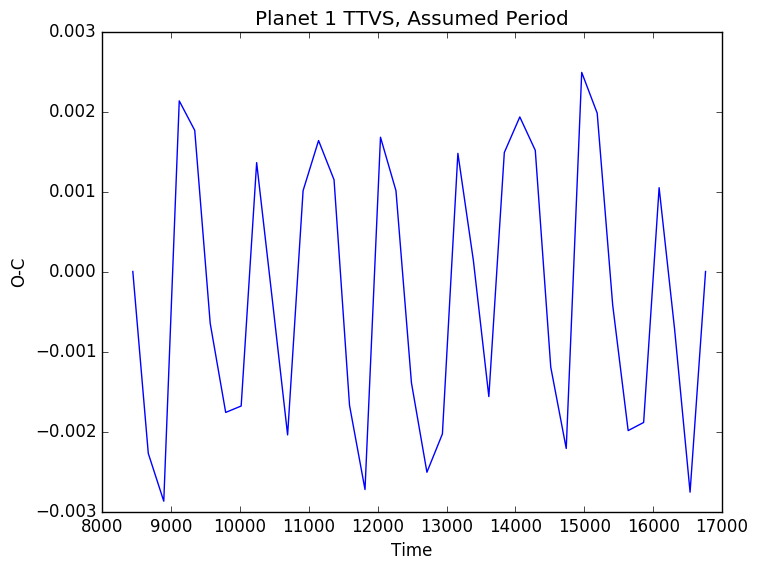

In [11]:
plot(t1,t1-reg_transits(per_guess1,t1[1],length(t1)))
xlabel("Time")
ylabel("O-C")
title("Planet 1 TTVS, Assumed Period") ;

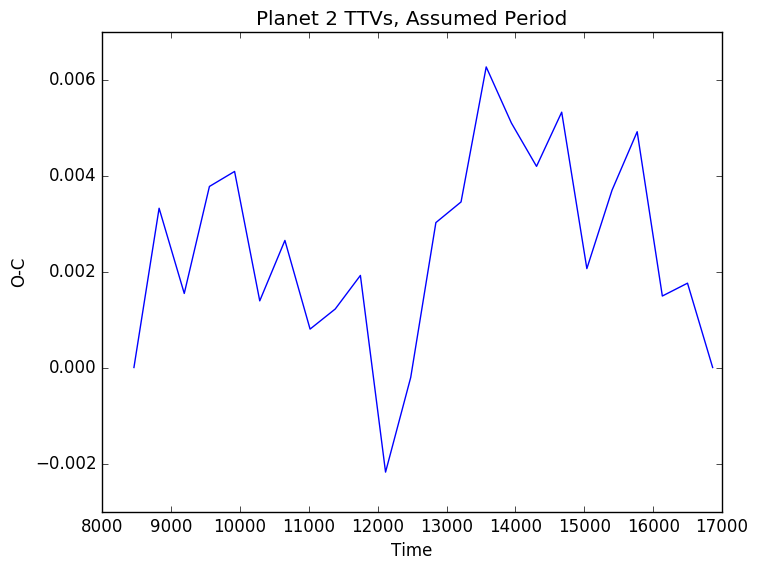

In [12]:
plot(t2,t2-reg_transits(per_guess2,t2[1],length(t2)))
xlabel("Time")
ylabel("O-C")
title("Planet 2 TTVs, Assumed Period") ;

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [15]:
make_plane(mass_ratio::Float64,period::Float64,t0::Float64,ecosw::Float64,esinw::Float64) = Planet_plane_hk(mass_ratio, period, t0, ecosw, esinw)

make_plane (generic function with 1 method)

In [43]:
function compute_ttv_pairs(n_p::Int64,n_trans_arr::Array{Int64},jmax::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64},1})
    
    ttvs = Array{Array{Float64}}(n_p)
    reg_times = Array{Array{Float64}}(n_p)
    
    #non_transiting planets
    if n_p >= length(n_trans_arr)
        
        for i=1:length(n_trans_arr)
            ttvs[i] = zeros(n_trans_arr[i])
            reg_times[i] = reg_transits(planets[i].trans0,planets[i].period,n_trans_arr[i])
        end
        for i=(length(n_trans_arr)+1):n_p
            ttvs[i] = [0.0]
            reg_times[i] = [0.0]
        end
        
    elseif n_p == length(n_trans_arr)
        
        for i=1:n_p
            ttvs[i] = zeros(n_trans_arr[i])
            trans_times[i] = reg_transits(planets[i].trans0,planets[i].period,n_trans_arr[i])
        end
    end
    
    for i=1:n_p-1 #for each planet
        for j=(i+1):n_p #go to each other planet
            time1 = trans_times[i]
            time2 = trans_times[j]
            ttvs1 = zeros(length(time1))
            ttvs2 = zeros(length(time2))
            compute_ttv!(jmax,planets[i],planets[j],time1,time2,ttvs1,ttvs2) #compute ttvs, add to array
            ttvs[i] .+= ttvs1 #add on to the TTVs
            ttvs[j] .+= ttvs2
        end
    end
    
    return (reg_times,ttvs,reg_times.+ttvs)
    
end

compute_ttv_pairs (generic function with 1 method)

In [101]:
[1.0,2.0]!=[2.0,3.0]

true

### 2. Carry out an initial fit to the transit times of the two planets.

In [102]:
function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
    
    flag = true
    
    #HELP ME I BROKE IT
    #tears
    #for (m,P,Psort,t0,ecos,esin) in zip(p[1:5:end],p[2:5:end],sort(p[2:5:end]),p[3:5:end],p[4:5:end],p[5:5:end])
    #    if (m <= 0)|(P<=0)|(P!=Psort)|(t0<=0)|(abs(ecos)>=1)|(abs(esin)>=1)
    #        flag = false
    #    end
    #end
    
    if sort(p[2:5:end])!=p[2:5:end] #Make sure that the inner periods is less than the outer periods
        flag=false
    end
    
    n_p = length(times)
    n_trans_arr = Int64[length(time) for time in times]
    
    if flag

        planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]

        regs,ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)

        lin_out = Float64[]
        for i=1:n_p
            append!(lin_out,trans_times[i])
        end

        return lin_out #regular transits plus the TTVS
        
    else
        
        return fill(1e10,sum(n_trans_arr))
        
    end
    
end

ttv_model (generic function with 1 method)

In [103]:
function fit_ttvs(n_p::Int64,times::Array{Array{Float64}})
        
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:n_p
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    p0 = zeros(5*n_p)
    #initialize params
    #p[1%5]-p[5%5] = mass_ratio, period, t0, ecosw, esinw for each planet
    for i=1:n_p
        p0[1+5*(i-1)] = 2.0e-6
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
        
    fit = curve_fit(ttv_model,times,lintimes,weights,p0)
    
end

fit_ttvs (generic function with 1 method)

In [104]:
result = fit_ttvs(2,data) ;

LoadError: LoadError: AssertionError: alpha < 1
while loading In[104], in expression starting on line 1

In [89]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2"]
for (nam,par) in zip(parnames,result.param)
    println("$nam = $par")
end

M_1 = 2.0000000011529464e-6
P_1 = 224.04923355362283
t0_1 = 8445.437789822641
ecosw_1 = 0.9999556186299507
esinw_1 = 0.33386762096059786
M_2 = 2.0000000011529464e-6
P_2 = 364.7943790707086
t0_2 = 8461.697757593362
ecosw_2 = -0.6091690658475123
esinw_2 = -0.00446554366713959


In [38]:
pars = result.param
np = 2
tarr = Int64[length(time) for time in data]
jm = 10
fit_plans = [make_plane(pars[1+5*(i-1)],pars[2+5*(i-1)],pars[3+5*(i-1)],pars[4+5*(i-1)],pars[5+5*(i-1)]) for i=1:np]
regs,ttvs,trans_times = compute_ttv_pairs(np,tarr,jm,fit_plans) ;

2.0e-6


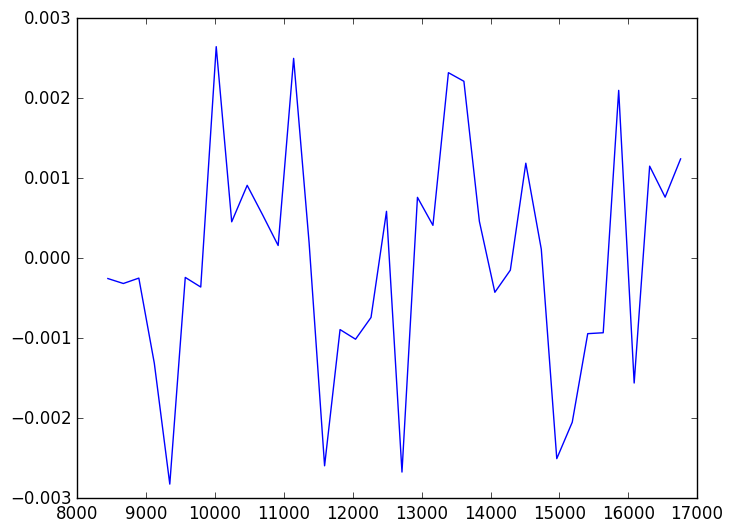

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31ce0aa50>

In [39]:
plot(t1,ttvs[1],"-b",label="Planet 1")
#plot(t1,(t1)-(trans_times[1]-ttvs[1]),"ob")
#plot(t2,ttvs[2],"-g",label="Planet 2")
#plot(t2,(t2)-(trans_times[2]-ttvs[2]),"og")
#title("Not the best fit ever")

In [ ]:
ttv_model(times,result.param) #WHY IS THIS HAPPENING

### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

### Lets edit our model such that we can account for asking for extra planets

In [ ]:
function fit_ttv_non_trans(n_p::Int64,times::Array{Array{Float64}})

    P_grid = logspace(log10(500),4)
    phase_grid = collect(0.0:10:0.9)

    P_best = 0.0
    phase_best = 0.0
    par_best = Float64[]
    chi_best = 1.0e14

    lintimes = Float64[]
    for i=1:n_p-1
        append!(lintimes,times[i])
    end

    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision

    p0 = zeros(5*n_p)
    #initialize params
    #p[1]-p[5] = mass_ratio, period, t0, ecosw, esinw, first planet
    #p[6] - p[10] = same params but second planet
    for i=1:n_p-1
        p0[1+5*(i-1)] = 2.0e-6
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
    append!(p0,[2.0e-6,0.1,0.1])

    for P in P_grid

        println(P)

        for phase in phase_grid

            t0 = phase*P

            function ttv_model_non_trans(times::Array{Array{Float64}},p::Array{Float64})

                splice!(p,length(p)-1,[P,t0,p[end-1]]) #push in the period and phase of our planet

                #enforce ecosw/esinw to be bounded to +/- 1
                for (ecos,esin) in zip(p[4:5:end],p[5:5:end])
                    if (abs(ecos)>=1)||(abs(esin)>=1)
                        return Inf
                    end
                end

                #enforce that, from inner planet to outer planet, periods must be in ascending order
                if sort(p[2:5:end]) != p[2:5:end]
                    return Inf
                end

                n_p = length(times)
                n_trans_arr = Int64[]
                for i=1:n_p
                    push!(n_trans_arr,length(times[i]))
                end
                planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]
                ttvs,trans_times = compute_ttv_pairs(n_p,n_trans_arr,10,planes)
                lin_out = Float64[]
                for i=1:n_p-1 #regular transits plus the TTVS; but just return the transiting planets
                    append!(lin_out,trans_times[i])
                end
                return lin_out 
            end

            fit = curve_fit(ttv_model_non_trans,times,lintimes,weights,p0)
            
            chi2 = sum((fit.resid.^2)./[(0.000347222^2.0) for i=1:fit.resid])
            
            if chi2 < chi_best
                chi_best = chi2
                P_best = P
                phase_best = phase
                par_best = fit.param
            end
            
        end
    end
end

In [ ]:
times = Array{Float64}[t1,t2]
fit_ttv_non_trans(3,times)

# To Do:
## 1. Clean up code. We use times as a variable like twelve times. 
## 2. Test all of the components of the code thus far, make sure they behave the way we want them too
## 3. Get the 3rd planet fitter working (test every line of fit_ttv_non_trans)
## 4. Start the MCMC fitter running; shouldn't be too hard